# Spideymaps: getting started
Author: Daniel Foust  
Last update: 2024-11-11

## Imports

In [7]:
import numpy as np

import spideymaps as sm

## Reading data

In [3]:
labels_sl, locs_csv = sm.read_map_data(
    labels_folders=[r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Spideymaps\cwx2695_LAM"],
    locs_folders=[r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Spideymaps\cwx2695_LAM"],
    labels_pattern="_PhaseMask.mat",
    locs_pattern="_AccBGSUB_fits_fits.csv",
    labels_format="smalllabs", # alternative "cellpose"
    locs_format="csv", # alternative "smalllabs"
    pixel_size=1, # for conversion if units are not pixels
    coord_cols=["row", "col"] # if using csv, specify which columns contain coordinates
)
# labels_list : list of 2d integer arrays
# locs_list : list of pandas DataFrames

# conversion from Matlab coordinates to Python
for locs in locs_csv:
    locs.loc[:,'row-1'] = locs.loc[:,'row'] - 1
    locs.loc[:,'col-1'] = locs.loc[:,'col'] - 1

## Calculate maps for individual cells

In [24]:
grid_params = dict(radius=10, 
                   n_shells=3, 
                   n_cols=8, 
                   n_phi=(1, 3, 4))
pixel_size = 0.049 # um

maps = []

for labels, locs in zip(labels_sl, locs_csv):
    n_cells = labels.max()
    # for c in range(1, n_cells+1):
    for c in np.unique(labels)[1:]:
        label = labels == c
        locs_cell = locs[locs['roinum']==c]
        map = sm.Spideymap(bimage=label, coords=locs_cell, xcol='col-1', ycol='row-1')
        try:
            map.make_grid(**grid_params)
            map.count(xcol='col-1', ycol='row-1')
            map.get_colicoords()
            map.coords['cell_length'] = map.mid.length
            maps.append(map)
        except:
            continue

## Aggregate into atlas

In [15]:
atlas = sm.SpideyAtlas(maps)

## Create representative grid

In [16]:
atlas.create_rep_grid(
    grid_params=grid_params,
    # cc_params=DEFAULT_CC_PARAMS,
    min_length=0,
    max_length=np.inf)

## Add counts and areas, and symmetrify

In [17]:
atlas.sum_coords(sumcol_name='count')
atlas.sum_maps(map_data_col='area')

atlas.add_symmetric_elements(col_name='count', 
                             symcol_name='count_quadsym', 
                             style='quad')
atlas.add_symmetric_elements(col_name='area', 
                             symcol_name='area_quadsym', 
                             style='quad')

c:\Users\djfoust\Anaconda3\envs\spideymaps_3\Lib\site-packages\spideymaps\spidey_atlas.py:453: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[sumcol_name].fillna(0, inplace=True)


## Calculate density (counts / pixels^2)

In [18]:
atlas.data['density_quadsym'] = atlas.data['count_quadsym'] / atlas.data['area_quadsym']

## Plot map

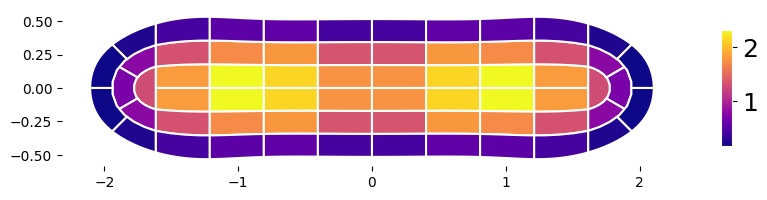

In [19]:
fig, ax = sm.render_map(
    atlas.rep_grid, 
    atlas.data['density_quadsym'].to_dict(),
    # vmin=vmin, 
    # vmax=vmax, 
    cmap='plasma',
    pixel_size=pixel_size)